# California Earthquake Data Preprocessing
## SE4050 - Deep Learning Assignment


---

## Notebook Purpose
This notebook performs data cleaning and preprocessing on raw USGS California earthquake data.

### Objectives:
1. Load raw earthquake data from USGS
2. Handle missing values and data quality issues
3. Validate geographic bounds and data ranges
4. Extract basic temporal features
5. Remove duplicates and invalid records
6. Save cleaned dataset for feature engineering

### Input:
- `data/raw/california_earthquakes.csv` - Raw USGS earthquake catalog

### Output:
- `data/processed/earthquakes_cleaned.csv` - Cleaned dataset
- `data/processed/preprocessing_summary.txt` - Processing summary
- `data/processed/cleaned_data_overview.png` - Visualization

---

In [1]:
# ============================================================================
# CALIFORNIA EARTHQUAKE DATA PREPROCESSING
# SE4050 Deep Learning Assignment
# ============================================================================
# Purpose: Clean raw USGS earthquake data for feature engineering
# Input: Raw USGS CSV from data exploration
# Output: Cleaned dataset ready for feature engineering
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully
Pandas version: 2.3.2
NumPy version: 2.3.3


---
## 1. Data Loading

Loading the raw earthquake dataset exported from USGS earthquake catalog.

**Expected data:**
- California earthquakes from 2015-2023
- Magnitude ≥ 3.5
- Approximately 1,542 records 

In [2]:
# Load the raw earthquake data (same file used in exploration)
df = pd.read_csv('../data/raw/earthquakes/california_earthquakes.csv')

print(f"Dataset loaded successfully")
print(f"Shape: {df.shape}")
print(f"Total earthquakes: {len(df)}")
print(f"\nColumns ({len(df.columns)}):")
print(df.columns.tolist())



Dataset loaded successfully
Shape: (6180, 27)
Total earthquakes: 6180

Columns (27):
['event_id', 'time', 'year', 'month', 'day', 'hour', 'minute', 'day_of_week', 'day_of_year', 'timestamp', 'latitude', 'longitude', 'depth_km', 'magnitude', 'magnitude_type', 'horizontal_uncertainty_km', 'depth_uncertainty_km', 'has_uncertainty', 'time_uncertainty_sec', 'azimuthal_gap_deg', 'stations_used', 'min_station_distance_deg', 'description', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']


---
## 2. Initial Data Inspection

Understanding the structure, data types, and basic statistics of our raw dataset.

In [3]:
# Display first few rows
print("First 5 rows:")
print(df.head())

print("\n" + "="*80)
print("Data types:")
print(df.dtypes)

print("\n" + "="*80)
print("Basic statistics:")
print(df.describe())

First 5 rows:
                                 event_id                     time  year  \
0  query?eventid=ci1049144&format=quakeml  1990-01-02 09:50:53.190  1990   
1  query?eventid=ci1049214&format=quakeml  1990-01-03 11:54:27.430  1990   
2   query?eventid=nc150384&format=quakeml  1990-01-08 21:04:52.830  1990   
3  query?eventid=ci1049754&format=quakeml  1990-01-11 01:22:10.300  1990   
4  query?eventid=ci1049832&format=quakeml  1990-01-11 23:08:57.980  1990   

   month  day  hour  minute  day_of_week  day_of_year  timestamp  ...  \
0      1    2     9      50            1            2  631273853  ...   
1      1    3    11      54            2            3  631367667  ...   
2      1    8    21       4            0            8  631832692  ...   
3      1   11     1      22            3           11  632020930  ...   
4      1   11    23       8            3           11  632099337  ...   

   has_uncertainty  time_uncertainty_sec  azimuthal_gap_deg  stations_used  \
0           

---
## 3. Missing Value Analysis

Identifying and quantifying missing data to determine cleaning strategy.

**Strategy:**
- Drop columns with 100% missing values (no information)
- Handle critical columns (lat, lon, magnitude, depth) by dropping rows
- Document all missing data for transparency

In [4]:
# Comprehensive missing value analysis
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})

missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

print("Missing Values Summary:")
print(missing_df.to_string(index=False))

print(f"\nTotal columns with missing values: {len(missing_df)}")
print(f"Columns with 100% missing: {len(missing_df[missing_df['Missing_Percentage'] == 100])}")

Missing Values Summary:
                   Column  Missing_Count  Missing_Percentage
horizontal_uncertainty_km           6180              100.00
     depth_uncertainty_km           6180              100.00
     time_uncertainty_sec           6180              100.00
        azimuthal_gap_deg           6180              100.00
 min_station_distance_deg           1587               25.68
            stations_used            262                4.24
                 depth_km             88                1.42

Total columns with missing values: 7
Columns with 100% missing: 4


### 3.1 Visualize Missing Data Pattern

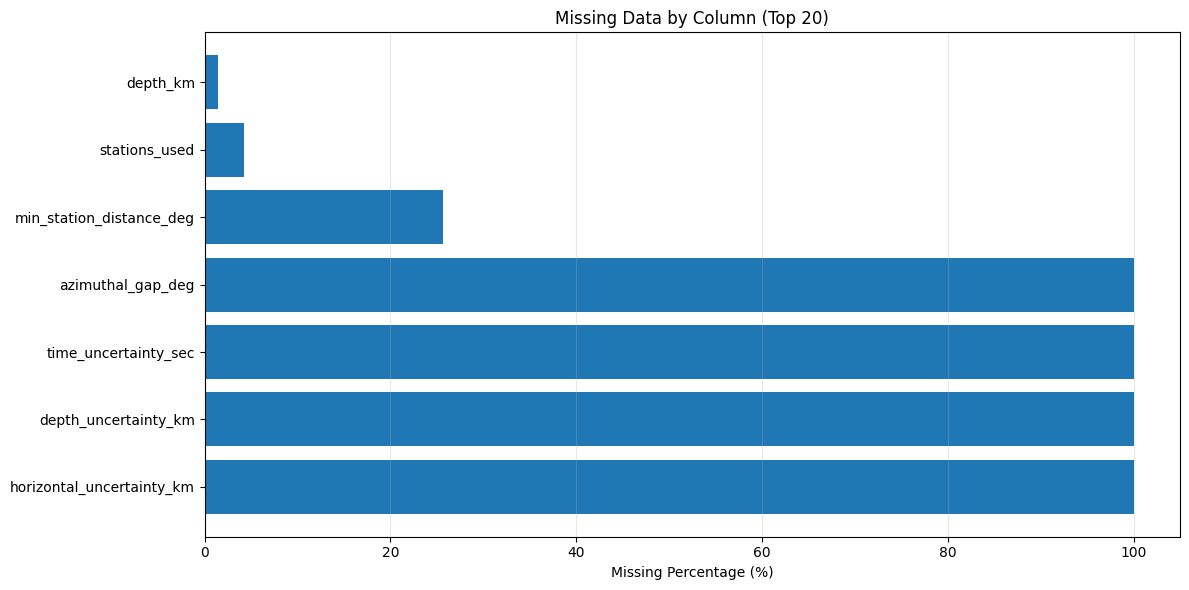

In [5]:
# Visualize missing data patterns
if len(missing_df) > 0:
    plt.figure(figsize=(12, 6))
    
    # Plot missing percentages
    cols_to_plot = missing_df.head(20)  # Top 20 columns with missing data
    plt.barh(cols_to_plot['Column'], cols_to_plot['Missing_Percentage'])
    plt.xlabel('Missing Percentage (%)')
    plt.title('Missing Data by Column (Top 20)')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No missing values in dataset!")

---
## 4. Data Cleaning - Remove Empty Columns

Dropping columns with 100% missing values as they provide no information for modeling.

In [6]:
# Drop columns that are completely empty (no information)
cols_100_missing = missing_df[missing_df['Missing_Percentage'] == 100]['Column'].tolist()

if cols_100_missing:
    print(f"Dropping {len(cols_100_missing)} columns with 100% missing values:")
    for col in cols_100_missing:
        print(f"  - {col}")
    
    df = df.drop(columns=cols_100_missing)
    print(f"\nNew shape: {df.shape}")
else:
    print("No columns with 100% missing values")

Dropping 4 columns with 100% missing values:
  - horizontal_uncertainty_km
  - depth_uncertainty_km
  - time_uncertainty_sec
  - azimuthal_gap_deg

New shape: (6180, 23)


---
## 5. Column Identification and Standardization

Identifying essential columns needed for deep learning analysis:
- **ID columns:** Unique earthquake identifiers
- **Time columns:** Temporal information
- **Location columns:** Latitude, longitude, depth
- **Magnitude columns:** Earthquake magnitude
- **Info columns:** Additional metadata

In [7]:
# Define essential columns for earthquake analysis
# Adjust these based on what's actually in your USGS data

essential_columns = {
    'id_cols': ['id', 'event_id', 'ids'],  # Possible ID column names
    'time_cols': ['time', 'datetime', 'origintime'],
    'location_cols': ['latitude', 'longitude', 'lat', 'lon', 'depth'],
    'magnitude_cols': ['mag', 'magnitude'],
    'info_cols': ['place', 'type', 'magType', 'status']
}

# Find which columns exist in our dataset
existing_cols = {}
for cat, cols in essential_columns.items():
    found = [col for col in cols if col in df.columns]
    if found:
        existing_cols[cat] = found

print("Essential columns found in dataset:")
for cat, cols in existing_cols.items():
    print(f"\n{cat}:")
    for col in cols:
        print(f"  - {col}")

# Show all current columns
print(f"\n\nAll current columns ({len(df.columns)}):")
print(df.columns.tolist())

Essential columns found in dataset:

id_cols:
  - event_id

time_cols:
  - time

location_cols:
  - latitude
  - longitude

magnitude_cols:
  - magnitude


All current columns (23):
['event_id', 'time', 'year', 'month', 'day', 'hour', 'minute', 'day_of_week', 'day_of_year', 'timestamp', 'latitude', 'longitude', 'depth_km', 'magnitude', 'magnitude_type', 'has_uncertainty', 'stations_used', 'min_station_distance_deg', 'description', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']


### 5.1 Standardize Column Names

Renaming columns to consistent naming convention for easier processing.

**Standard names:**
- `event_id` - Unique identifier
- `latitude`, `longitude` - Geographic coordinates
- `depth_km` - Depth in kilometers
- `magnitude` - Earthquake magnitude

In [8]:
# Rename columns to standard names for consistency
rename_map = {}

# ID column
if 'id' in df.columns:
    rename_map['id'] = 'event_id'
elif 'ids' in df.columns:
    rename_map['ids'] = 'event_id'

# Magnitude column
if 'mag' in df.columns:
    rename_map['mag'] = 'magnitude'

# Depth column (if it has a different name)
if 'depth' in df.columns and 'depth_km' not in df.columns:
    # Check if depth is in km or meters
    depth_median = df['depth'].median()
    if depth_median > 100:  # Likely in meters
        df['depth_km'] = df['depth'] / 1000
        print("Converted depth from meters to kilometers")
    else:
        rename_map['depth'] = 'depth_km'

# Location columns
if 'lat' in df.columns:
    rename_map['lat'] = 'latitude'
if 'lon' in df.columns:
    rename_map['lon'] = 'longitude'

# Apply renaming
if rename_map:
    df = df.rename(columns=rename_map)
    print("Renamed columns:")
    for old, new in rename_map.items():
        print(f"  {old} → {new}")
else:
    print("No columns needed renaming")

print(f"\nUpdated columns:")
print(df.columns.tolist())

No columns needed renaming

Updated columns:
['event_id', 'time', 'year', 'month', 'day', 'hour', 'minute', 'day_of_week', 'day_of_year', 'timestamp', 'latitude', 'longitude', 'depth_km', 'magnitude', 'magnitude_type', 'has_uncertainty', 'stations_used', 'min_station_distance_deg', 'description', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']


---
## 6. Temporal Data Processing

Converting time strings to datetime objects for temporal analysis.

**Why this matters:**
- Enables time-based feature extraction
- Required for LSTM sequential modeling
- Allows temporal pattern analysis

In [9]:
# Find the time column
time_col = None
for col in ['time', 'datetime', 'origintime']:
    if col in df.columns:
        time_col = col
        break

if time_col:
    print(f"Converting '{time_col}' to datetime...")
    
    # Show sample before conversion
    print(f"\nSample values before conversion:")
    print(df[time_col].head())
    
    # Convert to datetime
    df['time'] = pd.to_datetime(df[time_col], errors='coerce')
    
    # Check for conversion failures
    failed_conversions = df['time'].isnull().sum()
    if failed_conversions > 0:
        print(f"\nWarning: {failed_conversions} timestamps failed to convert")
    
    print(f"\nDatetime conversion successful!")
    print(f"Date range: {df['time'].min()} to {df['time'].max()}")
    
    # Drop original column if it had a different name
    if time_col != 'time':
        df = df.drop(columns=[time_col])
else:
    print("ERROR: No time column found!")

Converting 'time' to datetime...

Sample values before conversion:
0    1990-01-02 09:50:53.190
1    1990-01-03 11:54:27.430
2    1990-01-08 21:04:52.830
3    1990-01-11 01:22:10.300
4    1990-01-11 23:08:57.980
Name: time, dtype: object

Datetime conversion successful!
Date range: 1990-01-02 09:50:53.190000 to 2024-12-29 00:21:10.260000


### 6.1 Extract Basic Time Features

Creating temporal features that will be useful for all model types.

**Features created:**
- `year`, `month`, `day`, `hour`, `minute` - Standard temporal components
- `day_of_week` - Monday=0, Sunday=6
- `day_of_year` - 1-365/366
- `quarter` - Q1-Q4
- `is_weekend` - Binary flag for weekend earthquakes
- `timestamp` - Unix timestamp for numerical calculations

**Use cases:**
- DNN: Direct input features
- LSTM: Sequence ordering
- CNN: Temporal grid positioning
- GNN: Temporal edge weights

In [10]:
# Create time-based features for modeling
print("Extracting time-based features...")

df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute
df['day_of_week'] = df['time'].dt.dayofweek  # Monday=0, Sunday=6
df['day_of_year'] = df['time'].dt.dayofyear
df['quarter'] = df['time'].dt.quarter
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# Unix timestamp for numerical calculations
df['timestamp'] = df['time'].astype(np.int64) // 10**9

print("Time features created:")
time_features = ['year', 'month', 'day', 'hour', 'minute', 'day_of_week', 
                 'day_of_year', 'quarter', 'is_weekend', 'timestamp']
print(time_features)

# Show distribution
print(f"\nTemporal distribution:")
print(df['year'].value_counts().sort_index())

Extracting time-based features...
Time features created:
['year', 'month', 'day', 'hour', 'minute', 'day_of_week', 'day_of_year', 'quarter', 'is_weekend', 'timestamp']

Temporal distribution:
year
1990    160
1991    126
1992    724
1993    145
1994    304
1995    120
1996    108
1997    155
1998    142
1999    328
2000    117
2001     84
2002     88
2003    148
2004    125
2005    106
2006     96
2007     84
2008    168
2009    129
2010    545
2011    123
2012    119
2013    101
2014    128
2015    105
2016     91
2017     75
2018     61
2019    502
2020    325
2021    174
2022     98
2023    111
2024    165
Name: count, dtype: int64


---
## 7. Critical Column Validation

Verifying that all essential columns for deep learning modeling are present.

**Critical columns required:**
1. `event_id` - Unique identifier for tracking
2. `time` - Temporal information
3. `latitude`, `longitude` - Spatial coordinates
4. `depth_km` - Depth information
5. `magnitude` - Target variable for prediction

In [11]:
# Verify we have all critical columns for modeling
critical_columns = ['event_id', 'time', 'latitude', 'longitude', 'depth_km', 'magnitude']

print("Checking critical columns...")
missing_critical = [col for col in critical_columns if col not in df.columns]

if missing_critical:
    print(f"\nERROR: Missing critical columns: {missing_critical}")
    print("Available columns:", df.columns.tolist())
else:
    print("✓ All critical columns present")
    
    # Show statistics for critical columns
    print("\nCritical column statistics:")
    print(df[critical_columns].describe())

Checking critical columns...
✓ All critical columns present

Critical column statistics:
                                time     latitude    longitude     depth_km  \
count                           6180  6180.000000  6180.000000  6092.000000   
mean   2006-06-27 11:35:59.102482816    36.103115  -118.482091     7.275217   
min       1990-01-02 09:50:53.190000    32.000500  -124.999667    -2.722000   
25%    1995-10-01 03:02:17.284999936    34.066375  -119.744125     3.427500   
50%    2007-03-01 08:13:51.063000064    35.786500  -117.766817     6.103500   
75%    2016-09-01 17:58:14.587499776    38.173325  -116.356625     9.949000   
max       2024-12-29 00:21:10.260000    41.995100  -114.003667    44.841000   
std                              NaN     2.670005     2.731440     5.836349   

         magnitude  
count  6180.000000  
mean      3.909092  
min       3.500000  
25%       3.600000  
50%       3.790000  
75%       4.092500  
max       7.300000  
std       0.430816  


---
## 8. Handle Missing Values in Critical Columns

**Strategy:** Drop rows with missing values in critical columns.

**Rationale:**
- Cannot predict without location (lat/lon)
- Cannot predict without target variable (magnitude)
- Depth is essential for seismic analysis
- With 99.5%+ completeness, minimal data loss expected

**Assignment requirement:** This addresses the "Data Preprocessing (10%)" criterion for handling missing data.

In [12]:
# Check missing values in critical columns
print("Missing values in critical columns:")
critical_missing = df[critical_columns].isnull().sum()
print(critical_missing[critical_missing > 0])

# Count total rows before cleaning
rows_before = len(df)

# Drop rows with missing critical values
df_clean = df.dropna(subset=['latitude', 'longitude', 'magnitude', 'depth_km'])

rows_after = len(df_clean)
rows_removed = rows_before - rows_after

print(f"\nRows before: {rows_before}")
print(f"Rows after: {rows_after}")
print(f"Rows removed: {rows_removed} ({rows_removed/rows_before*100:.2f}%)")

# Update dataframe
df = df_clean.copy()

Missing values in critical columns:
depth_km    88
dtype: int64

Rows before: 6180
Rows after: 6092
Rows removed: 88 (1.42%)


---
## 9. Geographic Validation

Validating that earthquake locations fall within California boundaries.

**California approximate bounds:**
- Latitude: 32.5°N to 42.0°N
- Longitude: -124.5°W to -114.0°W

**Note:** Some earthquakes near borders may fall slightly outside these bounds. This is acceptable as seismic activity doesn't respect political boundaries.

In [13]:
# California approximate bounds
CA_BOUNDS = {
    'lat_min': 32.5,   # Southern border
    'lat_max': 42.0,   # Northern border
    'lon_min': -124.5, # Western coast
    'lon_max': -114.0  # Eastern border
}

print("Validating geographic bounds for California...")
print(f"Expected bounds: Lat [{CA_BOUNDS['lat_min']}, {CA_BOUNDS['lat_max']}], "
      f"Lon [{CA_BOUNDS['lon_min']}, {CA_BOUNDS['lon_max']}]")

# Check actual bounds
print(f"\nActual bounds in data:")
print(f"Latitude: [{df['latitude'].min():.2f}, {df['latitude'].max():.2f}]")
print(f"Longitude: [{df['longitude'].min():.2f}, {df['longitude'].max():.2f}]")

# Count out-of-bounds records
out_of_bounds = (
    (df['latitude'] < CA_BOUNDS['lat_min']) |
    (df['latitude'] > CA_BOUNDS['lat_max']) |
    (df['longitude'] < CA_BOUNDS['lon_min']) |
    (df['longitude'] > CA_BOUNDS['lon_max'])
)

n_out_of_bounds = out_of_bounds.sum()
print(f"\nRecords outside California bounds: {n_out_of_bounds} ({n_out_of_bounds/len(df)*100:.2f}%)")

if n_out_of_bounds > 0:
    print("\nSample out-of-bounds records:")
    print(df[out_of_bounds][['time', 'latitude', 'longitude', 'magnitude']].head())
    
    # Decision: keep or remove?
    # Usually keep if they're close (border earthquakes can be slightly outside)
    print("\nKeeping all records (border earthquakes may be slightly outside bounds)")

Validating geographic bounds for California...
Expected bounds: Lat [32.5, 42.0], Lon [-124.5, -114.0]

Actual bounds in data:
Latitude: [32.00, 41.99]
Longitude: [-125.00, -114.00]

Records outside California bounds: 780 (12.80%)

Sample out-of-bounds records:
                       time   latitude   longitude  magnitude
42  1990-03-24 07:44:09.230  40.333167 -124.631833       3.70
46  1990-03-31 22:59:48.030  32.379000 -115.239000       3.99
83  1990-05-01 08:41:02.480  32.100000 -117.634000       4.01
130 1990-10-05 03:17:54.990  32.466000 -115.436000       3.63
142 1990-11-03 13:47:21.570  40.884500 -124.999667       4.40

Keeping all records (border earthquakes may be slightly outside bounds)


---
## 10. Magnitude and Depth Validation

Validating physical constraints on earthquake measurements.

**Validation rules:**
- **Magnitude:** Should be between 0 and 10 (Richter scale limit ~9.5, but using 10 as safety margin)
- **Depth:** Should be between 0 and 700 km (deepest earthquakes ~700km in subduction zones)

Invalid values indicate data errors or quality issues that need removal.

In [14]:
print("Validating magnitude and depth values...")

# Magnitude validation
print("\nMagnitude statistics:")
print(df['magnitude'].describe())

mag_issues = (df['magnitude'] < 0) | (df['magnitude'] > 10)
print(f"Invalid magnitudes (< 0 or > 10): {mag_issues.sum()}")

# Depth validation
print("\nDepth statistics:")
print(df['depth_km'].describe())

depth_issues = (df['depth_km'] < 0) | (df['depth_km'] > 700)
print(f"Invalid depths (< 0 or > 700 km): {depth_issues.sum()}")

# Remove invalid records
invalid_records = mag_issues | depth_issues
if invalid_records.sum() > 0:
    print(f"\nRemoving {invalid_records.sum()} records with invalid magnitude/depth")
    df = df[~invalid_records].reset_index(drop=True)

print(f"\nFinal record count: {len(df)}")

Validating magnitude and depth values...

Magnitude statistics:
count    6092.000000
mean        3.906638
std         0.427971
min         3.500000
25%         3.600000
50%         3.790000
75%         4.090000
max         7.300000
Name: magnitude, dtype: float64
Invalid magnitudes (< 0 or > 10): 0

Depth statistics:
count    6092.000000
mean        7.275217
std         5.836349
min        -2.722000
25%         3.427500
50%         6.103500
75%         9.949000
max        44.841000
Name: depth_km, dtype: float64
Invalid depths (< 0 or > 700 km): 365

Removing 365 records with invalid magnitude/depth

Final record count: 5727


---
## 11. Duplicate Detection and Removal

Checking for duplicate records that could bias model training.

**Types of duplicates checked:**
1. **Exact duplicates:** Identical rows (rare)
2. **Duplicate event IDs:** Same earthquake recorded twice
3. **Near-duplicates:** Same location/time/magnitude (may be legitimate aftershocks)

**Strategy:** Remove duplicate event IDs, keep near-duplicates (may be real earthquake sequences).

In [15]:
print("Checking for duplicate records...")

# Check for exact duplicates
exact_duplicates = df.duplicated().sum()
print(f"Exact duplicate rows: {exact_duplicates}")

# Check for duplicate event IDs
if 'event_id' in df.columns:
    duplicate_ids = df['event_id'].duplicated().sum()
    print(f"Duplicate event IDs: {duplicate_ids}")
    
    if duplicate_ids > 0:
        print("\nRemoving duplicate event IDs (keeping first occurrence)...")
        df = df.drop_duplicates(subset=['event_id'], keep='first').reset_index(drop=True)
        print(f"Records after deduplication: {len(df)}")

# Check for near-duplicate earthquakes (same location, time, magnitude)
# Group by rounded values to find potential duplicates
df_temp = df.copy()
df_temp['lat_round'] = df_temp['latitude'].round(3)
df_temp['lon_round'] = df_temp['longitude'].round(3)
df_temp['mag_round'] = df_temp['magnitude'].round(1)
df_temp['time_hour'] = df_temp['time'].dt.floor('H')

near_duplicates = df_temp.duplicated(subset=['lat_round', 'lon_round', 'mag_round', 'time_hour']).sum()
print(f"\nNear-duplicate earthquakes (same location/time/magnitude within rounding): {near_duplicates}")

if near_duplicates > 0 and near_duplicates < 50:
    print("Keeping all records (may be legitimate earthquake sequences)")

Checking for duplicate records...
Exact duplicate rows: 0
Duplicate event IDs: 0

Near-duplicate earthquakes (same location/time/magnitude within rounding): 2
Keeping all records (may be legitimate earthquake sequences)


---
## 12. Chronological Sorting

Sorting data by time for temporal analysis and sequential modeling.

**Why this matters:**
- Required for LSTM time series analysis
- Enables calculation of "time since last event" features
- Facilitates temporal pattern discovery

In [16]:
# Sort by time for temporal analysis
df = df.sort_values('time').reset_index(drop=True)

print("Data sorted chronologically")
print(f"\nFirst earthquake: {df['time'].iloc[0]}")
print(f"Last earthquake: {df['time'].iloc[-1]}")
print(f"Time span: {(df['time'].iloc[-1] - df['time'].iloc[0]).days} days")

# Show temporal distribution
print(f"\nEarthquakes by year:")
print(df['year'].value_counts().sort_index())

Data sorted chronologically

First earthquake: 1990-01-02 09:50:53.190000
Last earthquake: 2024-12-29 00:21:10.260000
Time span: 12779 days

Earthquakes by year:
year
1990    149
1991    115
1992    587
1993    135
1994    270
1995    111
1996     95
1997    147
1998    125
1999    244
2000    107
2001     79
2002     87
2003    147
2004    120
2005    102
2006     91
2007     80
2008    162
2009    123
2010    538
2011    114
2012    117
2013     95
2014    108
2015    101
2016     87
2017     72
2018     60
2019    501
2020    323
2021    173
2022     95
2023    108
2024    159
Name: count, dtype: int64


---
## 13. Final Data Quality Summary

Comprehensive overview of cleaned dataset quality and characteristics.

In [17]:
print("="*80)
print("FINAL DATA QUALITY SUMMARY")
print("="*80)

print(f"\nDataset shape: {df.shape}")
print(f"Total earthquakes: {len(df)}")
print(f"Date range: {df['time'].min()} to {df['time'].max()}")

print(f"\n📊 Key Statistics:")
print(f"  Magnitude range: {df['magnitude'].min():.1f} - {df['magnitude'].max():.1f}")
print(f"  Median magnitude: {df['magnitude'].median():.1f}")
print(f"  Depth range: {df['depth_km'].min():.1f} - {df['depth_km'].max():.1f} km")
print(f"  Median depth: {df['depth_km'].median():.1f} km")

print(f"\n📍 Geographic Coverage:")
print(f"  Latitude: {df['latitude'].min():.2f}° to {df['latitude'].max():.2f}°")
print(f"  Longitude: {df['longitude'].min():.2f}° to {df['longitude'].max():.2f}°")

print(f"\n✓ Data Completeness:")
total_missing = df.isnull().sum().sum()
total_cells = df.shape[0] * df.shape[1]
completeness = (1 - total_missing/total_cells) * 100
print(f"  Overall completeness: {completeness:.2f}%")
print(f"  Missing values in critical columns: {df[critical_columns].isnull().sum().sum()}")

print(f"\n📅 Temporal Features:")
print(f"  Time features created: {len(time_features)}")
print(f"  Years covered: {df['year'].nunique()}")

FINAL DATA QUALITY SUMMARY

Dataset shape: (5727, 25)
Total earthquakes: 5727
Date range: 1990-01-02 09:50:53.190000 to 2024-12-29 00:21:10.260000

📊 Key Statistics:
  Magnitude range: 3.5 - 7.2
  Median magnitude: 3.8
  Depth range: 0.0 - 44.8 km
  Median depth: 6.5 km

📍 Geographic Coverage:
  Latitude: 32.00° to 41.99°
  Longitude: -125.00° to -114.00°

✓ Data Completeness:
  Overall completeness: 98.91%
  Missing values in critical columns: 0

📅 Temporal Features:
  Time features created: 10
  Years covered: 35


---
## 14. Final Column Selection

Selecting and organizing columns for the cleaned dataset.

**Column categories:**
- **Identifiers:** event_id
- **Temporal:** time, timestamp, and extracted time features
- **Spatial:** latitude, longitude, depth_km
- **Magnitude:** magnitude (primary target variable)
- **Metadata:** place, type, magType, status (if available)

In [18]:
# Select columns to keep in cleaned dataset
keep_columns = [
    # Identifiers
    'event_id',
    
    # Time (original and extracted features)
    'time', 'timestamp',
    'year', 'month', 'day', 'hour', 'minute',
    'day_of_week', 'day_of_year', 'quarter', 'is_weekend',
    
    # Location
    'latitude', 'longitude', 'depth_km',
    
    # Magnitude
    'magnitude',
]

# Add optional columns if they exist
optional_columns = ['place', 'type', 'magType', 'status', 'nst', 'gap', 'dmin', 'rms']
for col in optional_columns:
    if col in df.columns:
        keep_columns.append(col)

# Filter to keep only selected columns
available_keep = [col for col in keep_columns if col in df.columns]
df_final = df[available_keep].copy()

print(f"Selected {len(available_keep)} columns for cleaned dataset:")
print(available_keep)

print(f"\nFinal cleaned dataset shape: {df_final.shape}")

Selected 16 columns for cleaned dataset:
['event_id', 'time', 'timestamp', 'year', 'month', 'day', 'hour', 'minute', 'day_of_week', 'day_of_year', 'quarter', 'is_weekend', 'latitude', 'longitude', 'depth_km', 'magnitude']

Final cleaned dataset shape: (5727, 16)


---
## 15. Save Cleaned Dataset

Saving the processed data for use in feature engineering.

**Outputs:**
1. `earthquakes_cleaned.csv` - Main cleaned dataset
2. `preprocessing_summary.txt` - Text summary of preprocessing steps
3. Ready for next notebook: `03_feature_engineering.ipynb`

**For GitHub:** This cleaned dataset should be committed to track data quality improvements.

In [19]:
# Create output directory if it doesn't exist
import os
os.makedirs('../data/processed', exist_ok=True)

# Save cleaned dataset
output_file = '../data/processed/earthquakes_cleaned.csv'
df_final.to_csv(output_file, index=False)

print(f"✓ Cleaned dataset saved to: {output_file}")
print(f"  File size: {os.path.getsize(output_file) / 1024:.2f} KB")

# Also save a summary report
summary_file = '../data/processed/preprocessing_summary.txt'
with open(summary_file, 'w') as f:
    f.write("CALIFORNIA EARTHQUAKE DATA PREPROCESSING SUMMARY\n")
    f.write("="*80 + "\n\n")
    f.write(f"Processing date: {datetime.now()}\n")
    f.write(f"Input file: data/raw/california_earthquakes.csv\n")
    f.write(f"Output file: {output_file}\n\n")
    f.write(f"Records: {len(df_final)}\n")
    f.write(f"Features: {len(df_final.columns)}\n")
    f.write(f"Date range: {df_final['time'].min()} to {df_final['time'].max()}\n")
    f.write(f"Completeness: {completeness:.2f}%\n\n")
    f.write("Columns:\n")
    for col in df_final.columns:
        f.write(f"  - {col}\n")

print(f"✓ Summary report saved to: {summary_file}")

✓ Cleaned dataset saved to: ../data/processed/earthquakes_cleaned.csv
  File size: 730.95 KB
✓ Summary report saved to: ../data/processed/preprocessing_summary.txt


---
## 16. Visualization of Cleaned Data

Creating summary visualizations to verify data quality and distributions.

**Visualizations:**
1. **Magnitude distribution** - Verify expected frequency-magnitude relationship
2. **Depth distribution** - Check for realistic depth patterns
3. **Temporal distribution** - Ensure consistent coverage across years
4. **Spatial distribution** - Verify California geographic coverage

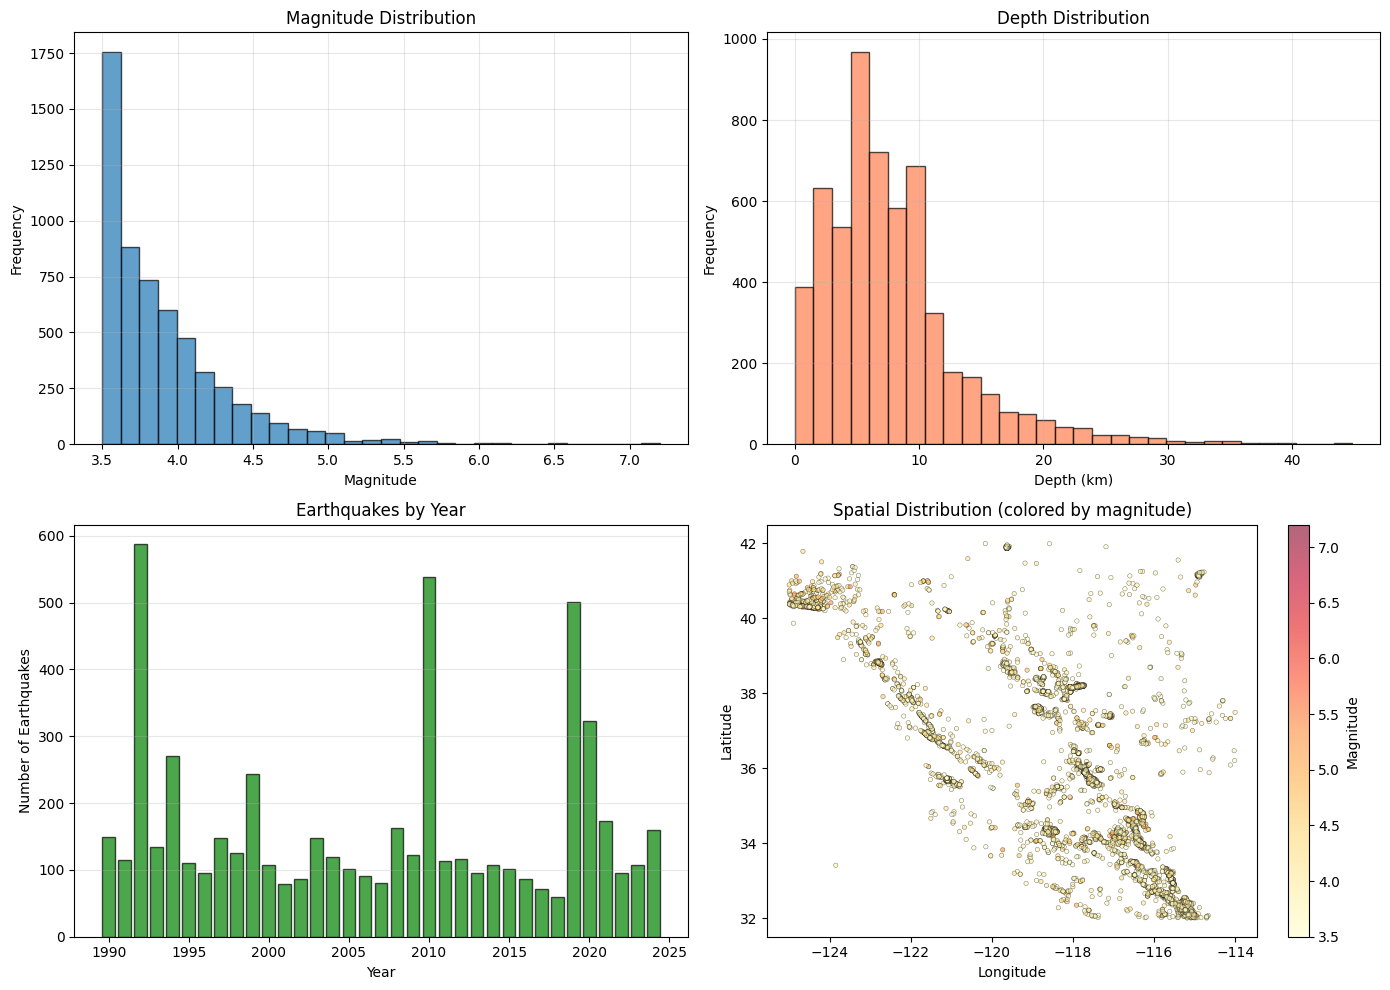

✓ Visualization saved to: data/processed/cleaned_data_overview.png


In [20]:
# Create a quick visualization dashboard
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Magnitude distribution
axes[0, 0].hist(df_final['magnitude'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Magnitude')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Magnitude Distribution')
axes[0, 0].grid(alpha=0.3)

# 2. Depth distribution
axes[0, 1].hist(df_final['depth_km'], bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_xlabel('Depth (km)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Depth Distribution')
axes[0, 1].grid(alpha=0.3)

# 3. Temporal distribution
yearly_counts = df_final['year'].value_counts().sort_index()
axes[1, 0].bar(yearly_counts.index, yearly_counts.values, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Number of Earthquakes')
axes[1, 0].set_title('Earthquakes by Year')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Spatial distribution
scatter = axes[1, 1].scatter(df_final['longitude'], df_final['latitude'], 
                             c=df_final['magnitude'], cmap='YlOrRd', 
                             s=10, alpha=0.6, edgecolors='black', linewidths=0.3)
axes[1, 1].set_xlabel('Longitude')
axes[1, 1].set_ylabel('Latitude')
axes[1, 1].set_title('Spatial Distribution (colored by magnitude)')
plt.colorbar(scatter, ax=axes[1, 1], label='Magnitude')

plt.tight_layout()
plt.savefig('../data/processed/cleaned_data_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to: data/processed/cleaned_data_overview.png")